In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os

# -------- Data Loading for a Single Node --------
def load_single_node_data(folder_path):
    all_data = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            if '5 Minutes' in df.columns and 'Flow (Veh/5 Minutes)' in df.columns:
                df['5 Minutes'] = pd.to_datetime(df['5 Minutes'], errors='coerce')
                df = df.set_index('5 Minutes')
                all_data.append(df[['Flow (Veh/5 Minutes)']])
    
    combined_data = pd.concat(all_data)
    combined_data = combined_data.sort_index()
    combined_data = combined_data.dropna()  # Remove missing data
    return combined_data

# Load data for one node (you can change folder path accordingly)
folder_path = '../Data/402510'
data = load_single_node_data(folder_path)

# Normalize the data
# scaler = MinMaxScaler()
# data['Flow (Veh/5 Minutes)'] = scaler.fit_transform(data[['Flow (Veh/5 Minutes)']])

# Prepare the data for LSTM
def prepare_lstm_data(data, input_window=10, output_window=5):
    X, Y = [], []
    data_values = data.values
    for i in range(len(data_values) - input_window - output_window + 1):
        X.append(data_values[i:i+input_window])
        Y.append(data_values[i+input_window:i+input_window+output_window])
    
    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32)
    return X, Y

input_window = 10
output_window = 5

# Split data into train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size

train_data, val_data, test_data = np.split(data, [train_size, train_size + val_size])

X_train, Y_train = prepare_lstm_data(train_data, input_window, output_window)
X_val, Y_val = prepare_lstm_data(val_data, input_window, output_window)
X_test, Y_test = prepare_lstm_data(test_data, input_window, output_window)

# Create DataLoader for train, val, and test sets
def create_dataloader(X, Y, batch_size):
    dataset = TensorDataset(X, Y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch_size = 32
train_loader = create_dataloader(X_train, Y_train, batch_size)
val_loader = create_dataloader(X_val, Y_val, batch_size)
test_loader = create_dataloader(X_test, Y_test, batch_size)

# -------- LSTM Model --------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_window):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * output_window)
        self.output_window = output_window
        self.output_dim = output_dim

    def forward(self, x):
        # x shape: (batch_size, input_window, input_dim)
        lstm_out, _ = self.lstm(x)  # (batch_size, input_window, hidden_dim)
        lstm_out = lstm_out[:, -1, :]  # Take only the last output
        output = self.fc(lstm_out)  # (batch_size, output_dim * output_window)
        output = output.view(-1, self.output_window, self.output_dim)  # Reshape
        return output

# Model parameters
input_dim = 1  # Since we're using only the flow values
hidden_dim = 128
output_dim = 1  # We are predicting a single time series (flow)
output_window = 5

# Initialize the model
model = LSTMModel(input_dim, hidden_dim, output_dim, output_window)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

# -------- Train the Model --------
def train_model(model, train_loader, val_loader, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                val_predictions = model(X_val)
                val_loss += criterion(val_predictions, Y_val).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break
    
    return best_model

# Train the model
best_model = train_model(model, train_loader, val_loader, num_epochs=10)

# Load the best model
model.load_state_dict(best_model)




Epoch 1, Train Loss: 5448.8014, Val Loss: 1039.9599
Saved new best model with validation loss: 1039.9599
Epoch 2, Train Loss: 502.4516, Val Loss: 267.1951
Saved new best model with validation loss: 267.1951
Epoch 3, Train Loss: 248.0048, Val Loss: 208.2498
Saved new best model with validation loss: 208.2498
Epoch 4, Train Loss: 222.5023, Val Loss: 197.3670
Saved new best model with validation loss: 197.3670
Epoch 5, Train Loss: 217.6947, Val Loss: 204.0797
Epoch 6, Train Loss: 217.7081, Val Loss: 199.3810
Epoch 7, Train Loss: 213.9034, Val Loss: 195.6324
Saved new best model with validation loss: 195.6324
Epoch 8, Train Loss: 212.8208, Val Loss: 196.2518
Epoch 9, Train Loss: 211.3029, Val Loss: 192.9300
Saved new best model with validation loss: 192.9300
Epoch 10, Train Loss: 210.6999, Val Loss: 190.0056
Saved new best model with validation loss: 190.0056


<All keys matched successfully>

RMSE: 16.1289
R² Score: 0.8925
MAE: 11.1112
Time taken: 0.25 seconds


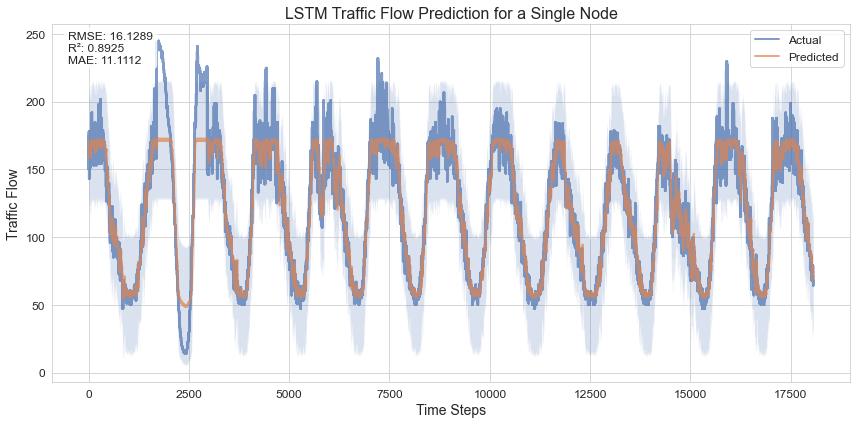

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import torch
import seaborn as sns

def visualize_predictions(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    start = time.time()
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            preds = model(X_batch).cpu().numpy()
            predictions.append(preds)
            actuals.append(Y_batch.cpu().numpy())
    end = time.time()

    # Concatenate predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Reshape predictions and actuals if necessary
    if predictions.ndim > 2:
        predictions = predictions.reshape(predictions.shape[0], -1)
    if actuals.ndim > 2:
        actuals = actuals.reshape(actuals.shape[0], -1)

    # Inverse transform the predictions and actuals
    # predictions = scaler.inverse_transform(predictions)
    # actuals = scaler.inverse_transform(actuals)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Time taken: {end - start:.2f} seconds")

    # Set the style for the plot
    sns.set_style("whitegrid")
    sns.set_palette("deep")

    # Plot predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(actuals.flatten(), label="Actual", linewidth=2, alpha=0.7)
    plt.plot(predictions.flatten(), label="Predicted", linewidth=2, alpha=0.7)
    
    plt.legend(fontsize=12)
    plt.title("LSTM Traffic Flow Prediction for a Single Node", fontsize=16)
    plt.xlabel("Time Steps", fontsize=14)
    plt.ylabel("Traffic Flow", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Add shaded area for prediction uncertainty
    plt.fill_between(range(len(actuals.flatten())), 
                     predictions.flatten() - predictions.flatten().std(), 
                     predictions.flatten() + predictions.flatten().std(), 
                     alpha=0.2)
    
    # Add text box with metrics
    plt.text(0.02, 0.98, f'RMSE: {rmse:.4f}\nR²: {r2:.4f}\nMAE: {mae:.4f}', 
             transform=plt.gca().transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_predictions(model, test_loader)
